# Gaussian Process Regression on dataset of model measurement (SL)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import scipy as sci
from scipy.stats import chi2
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [29]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [31]:
mcs = [ 'BPSK 1/2', 'BPSK 3/4', 'QPSK 1/2', 'QPSK 3/4',
        '16QAM 1/2', '16QAM 3/4', '64QAM 2/3', '64QAM 3/4']

## Read and calculate data

In [6]:
# load data
df = pd.read_csv('../agentdata/rssi_sl_raw.csv')

In [7]:
# get dataset of best action for each observation (obs and label)
cols = []
for i in range(64):
    cols.append('Sc' + str(i))

df['Run'] = df.apply(lambda row: int(row.name / 8), axis=1)
df = df[df['Reward'] > 0.0]

obs = []
label = []

for run in df['Run'].unique():
    runData = df[df['Run'] == run]
    myid = runData['Reward'].idxmax()
    myrow = df.loc[myid]
    label.append(myrow['Action'])
    obs.append(myrow[cols].to_numpy())

In [8]:
df['Dist'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [9]:
# take average observation over all 64 subcarriers
data = []
for elem in obs:
    elem = np.average(elem)
    elem = (elem - 0) / 45 
    elem = np.reshape(elem, [1, ])
    data.append(elem)
data = np.array(data)

In [10]:
# randomize data (Data augmentation)
new_data = data
new_label =[]
new_label.extend(label)

for i in range(5):
    new_data = np.append(new_data, data + np.random.normal(0,0.005,len(data)).reshape(len(data),1))
    new_label.extend(label)
len(new_data)

660

In [11]:
gpdata = new_data.reshape(-1,1)
gplabel = np.array(new_label)
gplabel = gplabel.reshape(-1,1)

## Train the model

In [12]:
kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level= 0.5)
gpBad = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gpBad.fit(gpdata, gplabel)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.5))

In [13]:
df = pd.DataFrame(data, columns=['Obs'])
df['Action'] = label

## Evaluate the model

In [21]:
linEval = np.linspace(gpdata.min(), gpdata.max(), num=1000).reshape(-1, 1)
y_linEval, sigma_linEval = gpBad.predict(linEval, return_std=True)
y_data, sigma_data = gpBad.predict(data, return_std=True)
df['predict'] = y_data
df['Outlier'] = df.apply(lambda row: np.abs(row['Action'] - row['predict']) > 0.5, axis = 1) 

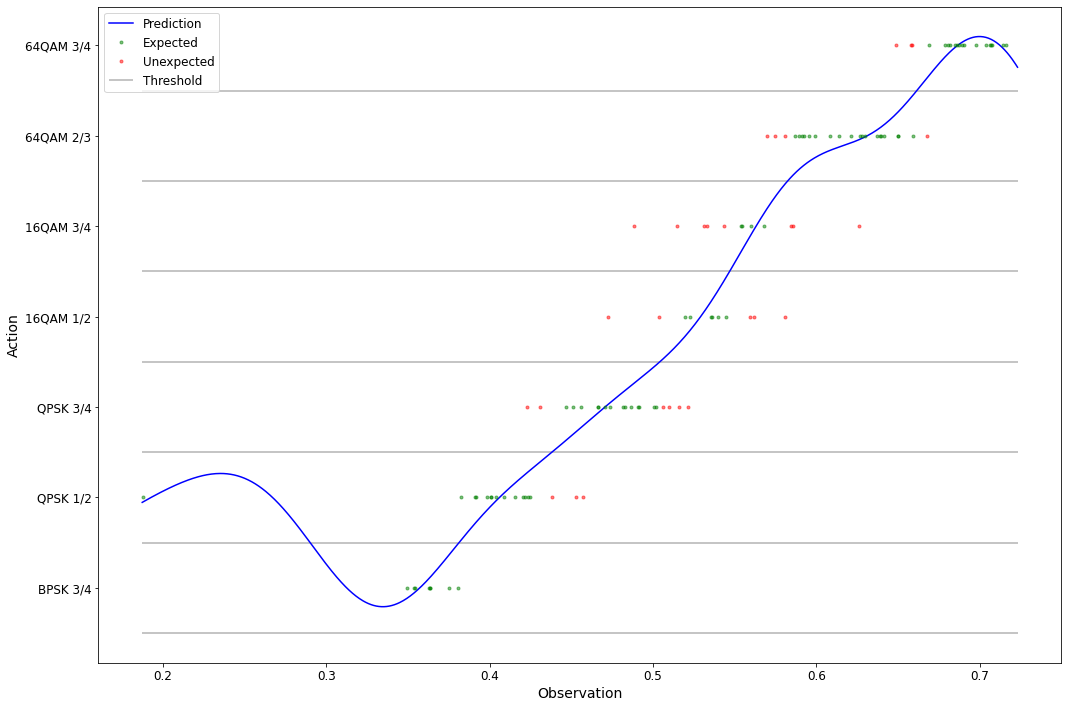

In [37]:
fig = plt.figure(figsize=(15,10))

normal = df[df['Outlier'] == False]
outlier = df[df['Outlier'] == True]

plt.plot(linEval, y_linEval, 'b', label='Prediction')
#plt.fill_between(linEval[:,0], y1 = (y_linEval[:,0]-1.96*sigma_linEval), y2 = (y_linEval[:,0]+1.96*sigma_linEval), color='b', alpha=.6)
plt.yticks(range(8), mcs)
plt.xlabel('Observation')
plt.ylabel('Action')
plt.hlines([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], gpdata.min(), gpdata.max(), 'k', alpha=0.3,label="Threshold")
plt.plot(normal['Obs'], normal['Action'], '.g', alpha = 0.5, label="Expected")
plt.plot(outlier['Obs'], outlier['Action'], '.r', alpha = 0.5, label="Unexpected")
plt.legend()
plt.tight_layout()
plt.savefig('eval_gpr.pdf')
plt.savefig('eval_gpr.png')

In [14]:
print("Error= " + str(len(outlier) / (len(outlier) + len(normal))))

Error= 0.2545454545454545
